In [1]:
import numpy as np
from scipy.io import loadmat
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import mne
data_path = mne.datasets.sample.data_path()
subjects_dir = data_path + '/subjects'
sample_dir = data_path + '/MEG/sample'
surf_dir = subjects_dir + '/sample/surf'

In [3]:
# Read in some raw data
raw = mne.io.read_raw_fif(sample_dir + '/sample_audvis_raw.fif',
                          preload=True)
raw.pick_types(meg=False, eeg=True)

Opening raw data file /Users/liberty/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 59 x 166800 (277.7 sec), ~78.2 MB, data loaded>

## Plot EEG sensors on the head

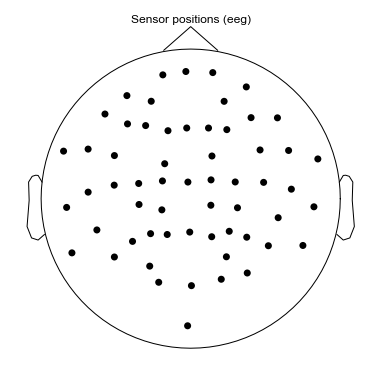

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
raw.plot_sensors(axes=ax);
# raw.info

## Plot the data with matplotlib

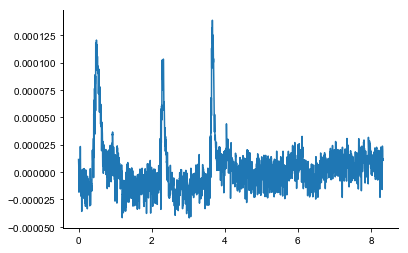

In [11]:
# Extract the timecourse
data_eeg, times = raw[:10, :5000]

# Plot the data
fig, ax = plt.subplots()
ax.plot(times, data_eeg[0])

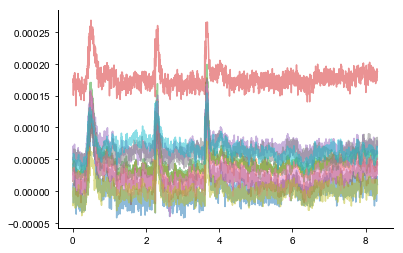

In [12]:
# We can even plot lots of raw data!
fig, ax = plt.subplots()
ax.plot(times, data_eeg[:10].T, alpha=.5);

## But we can do this in MNE!

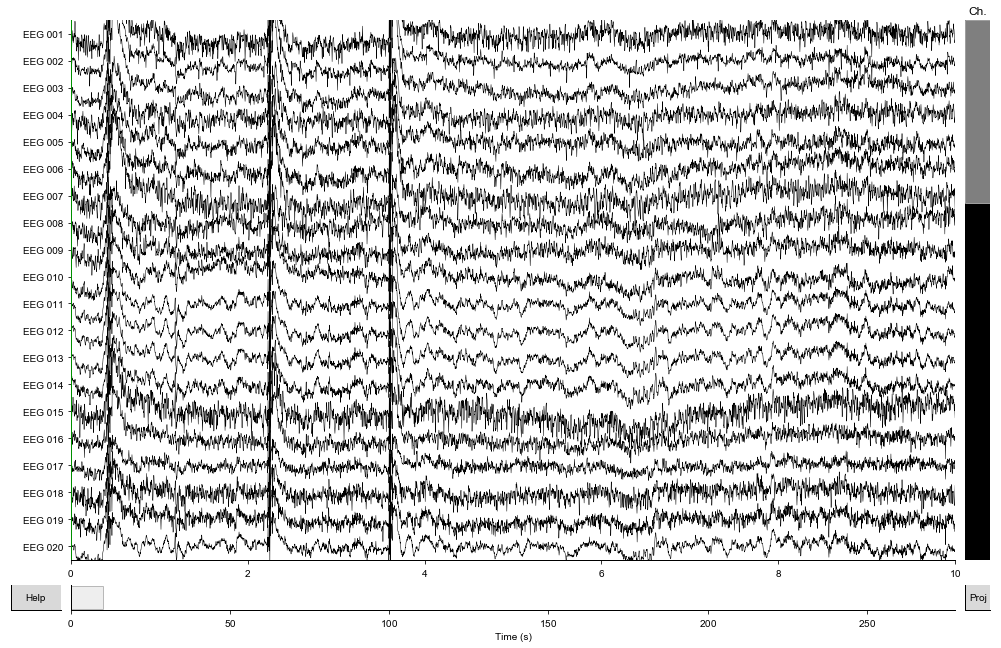

In [13]:
raw.plot();

## Filtering the data

Setting up band-pass filter from 1 - 4 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 1983 samples (3.302 sec) selected


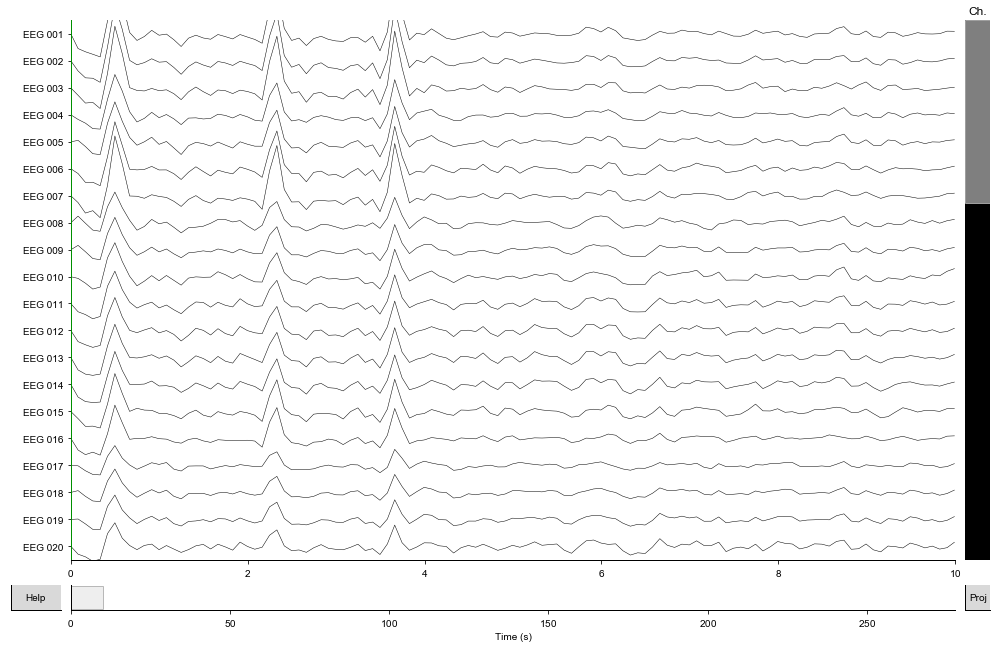

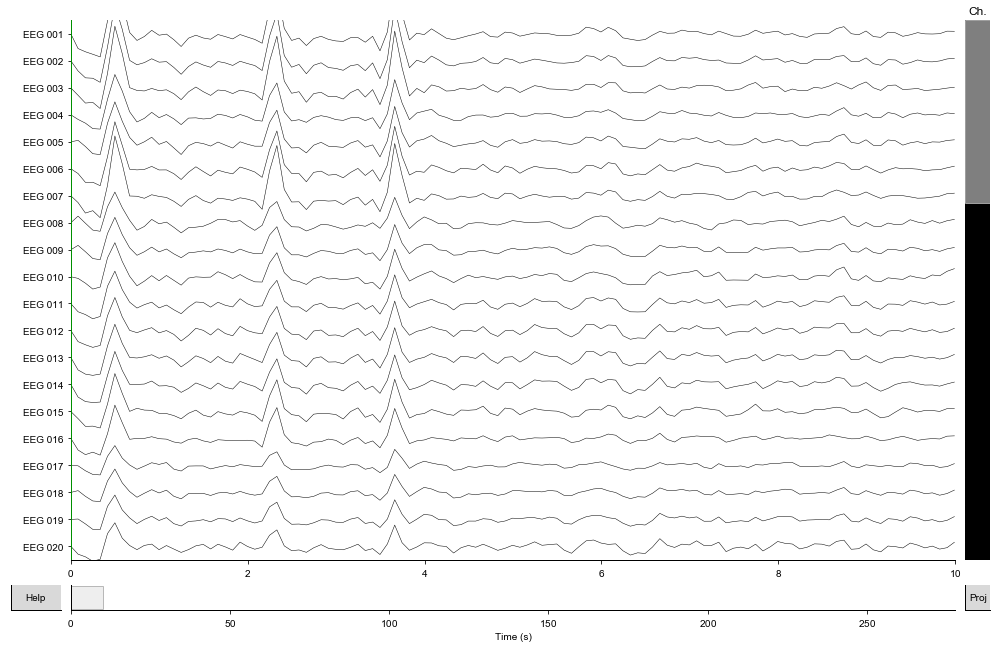

In [14]:
delta = raw.copy()
delta.filter(l_freq=1.0, h_freq=4.0)
delta.plot()

## Removing artifacts with ICA

Read more here! 

https://martinos.org/mne/stable/auto_examples/preprocessing/plot_ica_comparison.html#sphx-glr-auto-examples-preprocessing-plot-ica-comparison-py

In [ ]:
from mne.preprocessing import ICA

# ICA works better with highpass filtered data
highpass_data = raw.copy()
highpass_data.filter(l_freq=1.0, h_freq=None)

ica = ICA(n_components=raw.info['nchan'], method='infomax')
ica.fit(highpass_data)

Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 1983 samples (3.302 sec) selected
Fitting ICA to data using 59 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 59 components
 


In [ ]:
# Plot the independent components
ica.plot_components()

In [ ]:
exclude_ics = [0,7]
ica.plot_overlay(highpass_data, exclude=exclude_ics)


In [ ]:
ica.apply(highpass_data, exclude=exclude_ics)

In [ ]:
highpass_data.plot();

In [ ]:
highpass_data.set_eeg_reference(ref_channels='average')

## Add events to mark important stuff happening during a task

In [ ]:
# Read in event timings
event_id = {'auditory': 1, 'visual': 3}
events = mne.read_events(sample_dir + '/sample_audvis_raw-eve.fif',
                         include=list(event_id.values()))
print(events[:5])

In [ ]:
raw.plot(events=events, event_color='red', duration=20, scalings='auto');

In [ ]:
highpass_data.plot(events=events, event_color='red', duration=20, scalings='auto');

In [ ]:
# Create epochs
epochs = mne.Epochs(highpass_data, events, event_id)

print('\n---\n\n', epochs.get_data().shape)

In [ ]:
epochs.plot_image(combine='mean')

In [ ]:
epochs.plot(n_epochs=5, scalings='auto');

In [ ]:
epochs.average().plot();

In [ ]:
# Plot the mean response for each subset
for kind in event_id.keys():
    # Take the subset and calculate the average
    subset = epochs[kind]
    av = subset.average()
    
    # Only take a subset of electrodes
    ixs_plot = mne.pick_types(av.info, meg=False, eeg=True)

    # Make the plot
    _ = av.plot_joint(picks=ixs_plot, title=kind)

In [ ]:
# Create epochs including different events
tmin = -0.2
tmax = 2
event_id = {'audio/left': 1, 'audio/right': 2,
            'visual/left': 3, 'visual/right': 4}
events = mne.read_events(sample_dir + '/sample_audvis_raw-eve.fif',
                         include=list(event_id.values()))

epochs = mne.Epochs(highpass_data, events, event_id, tmin, tmax,
                    baseline=(None, 0))

# Generate list of evoked objects from conditions names
evokeds = [epochs[name].average() for name in ('left', 'right')]

In [ ]:
mne.viz.plot_compare_evokeds(evokeds)